In [16]:
import sys

sys.path.append('/home/arda/dinov2/distillation')

from models.stdc_wrapper import STDCWrapper

resnet = STDCWrapper()
resnet_tpp = STDCWrapper()

In [17]:
from losses import ScaleKD

scalekd_head = ScaleKD(name='arda',
                       use_this=True,
                 alpha = [0.08, 0.06],
                 student_dims = 1024,
                 teacher_dims = 384,
                 query_hw = [16,16],
                 pos_hw= [16,16],
                 pos_dims = 384,
                 window_shapes=(1,1),
                 self_query=True,
                 softmax_scale=[1,1],
                 dis_freq='high',
                 num_heads=16
                 )

scalekd_head_tpp = ScaleKD(name='arda',
                       use_this=True,
                 alpha = [0.08, 0.06],
                 student_dims = 1024,
                 teacher_dims = 384,
                 query_hw = [16,16],
                 pos_hw= [16,16],
                 pos_dims = 384,
                 window_shapes=(1,1),
                 self_query=True,
                 softmax_scale=[1,1],
                 dis_freq='high',
                 num_heads=16
                 )

In [18]:
projector = scalekd_head.projector_0
projector_tpp = scalekd_head_tpp.projector_0



In [20]:
import torch
ckpt = torch.load('/home/arda/dinov2/distillation/logs/stdc2/distillation/version_179/checkpoints/last.ckpt')
ckpt_tpp = torch.load('/home/arda/dinov2/distillation/logs/stdc2/distillation/version_0/checkpoints/last.ckpt')

/home/arda/tmp/ipykernel_460792/460971937.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/home/arda/dinov2/distillation/logs/stdc2/distillation/versi

In [21]:
proj_tpp = {key.replace('losses.scalekd_last.projector_0.', ''): value for key, value in ckpt_tpp['state_dict'].items() if 'scalekd_last.projector_0' in key  }
proj = {key.replace('losses.scalekd_res5.projector_0.', ''): value for key, value in ckpt['state_dict'].items() if 'scalekd_res5.projector_0' in key  }

In [22]:
proj

{'pos_embed': tensor([[[[-4.2874e-02, -1.7195e-02,  7.8616e-02,  ..., -1.2642e-01,
            -1.2591e-02, -6.0038e-02],
           [-9.6915e-02, -1.6271e-02, -1.0006e-01,  ...,  2.7932e-02,
             7.0382e-03, -1.3006e-01],
           [-5.8341e-02,  2.7038e-02,  4.1429e-02,  ..., -1.0045e-01,
             4.7554e-02, -5.5744e-02],
           ...,
           [ 1.6924e-02, -4.7204e-02,  3.4778e-02,  ...,  9.5492e-03,
            -1.4720e-02, -4.1627e-02],
           [-5.9220e-02,  7.8575e-02, -2.7071e-02,  ..., -1.3590e-01,
            -4.3058e-02, -6.4211e-02],
           [-5.8464e-02, -5.0554e-02, -4.3557e-02,  ..., -1.8476e-02,
            -4.0395e-02, -6.3268e-02]],
 
          [[-3.4206e-02,  1.6177e-02, -1.4224e-02,  ...,  5.8944e-02,
            -8.2467e-02, -3.4706e-02],
           [-4.3670e-02, -4.4188e-02,  9.8489e-03,  ..., -9.3833e-02,
            -8.3931e-02, -4.1353e-02],
           [-3.9861e-02, -1.0677e-01, -1.3079e-01,  ..., -1.4770e-01,
            -4.9649e-02, -

In [23]:
proj_tpp.keys()

dict_keys(['pos_embed', 'proj_pos.0.weight', 'proj_pos.0.bias', 'proj_student.0.weight', 'proj_student.0.bias', 'proj_student.1.weight', 'proj_student.1.bias', 'proj_student.1.running_mean', 'proj_student.1.running_var', 'proj_student.1.num_batches_tracked', 'pos_attention.q.weight', 'pos_attention.q.bias', 'pos_attention.k.weight', 'pos_attention.k.bias', 'pos_attention.v.weight', 'pos_attention.v.bias', 'pos_attention.proj.weight', 'pos_attention.proj.bias', 'ffn.layers.0.0.weight', 'ffn.layers.0.0.bias', 'ffn.layers.1.weight', 'ffn.layers.1.bias', 'norm.weight', 'norm.bias'])

In [24]:
w_student = {k.replace('student.model.', ''): v for k, v in ckpt['state_dict'].items() if 'student' in k and 'scalekd' not in k and 'feature_matchers' not in k}
w_student_tpp = {k.replace('student.model.', ''): v for k, v in ckpt_tpp['state_dict'].items() if 'student' in k and 'scalekd' not in k and 'feature_matchers' not in k}

In [25]:
# projector.load_state_dict(proj)
# projector_tpp.load_state_dict(proj_tpp)
projector.load_state_dict(proj, strict=False)

_IncompatibleKeys(missing_keys=['query.weight'], unexpected_keys=[])

In [26]:
resnet.load_state_dict(w_student)
resnet = resnet.model
resnet_tpp.load_state_dict(w_student_tpp)
resnet_tpp = resnet_tpp.model

In [27]:
from PIL import Image
import torchvision.transforms as transforms

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize(448),             # Resize the shorter side to 256 pixels (preserving aspect ratio)
    transforms.CenterCrop(448),         # Crop to 224x224 pixels, which is expected by ResNet
    transforms.ToTensor(),              # Convert the PIL image to a PyTorch tensor (shape: [C, H, W])
    transforms.Normalize(               # Normalize using ImageNet's mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# Load a sample image (make sure your image path is correct)
sample_image_path = '/home/arda/dinov2/distillation/notebooks/licensed-image.jpeg'
img = Image.open(sample_image_path).convert('RGB')  # Ensure image is in RGB format

# Apply the defined transform to the image
img_transformed = transform(img)

# ResNet expects a batch of images, so add a batch dimension: [B, C, H, W]
img_batch = img_transformed.unsqueeze(0)

# Now feed the sample image to the resnet model
output = resnet(img_batch)
# output = projector(output['res5'])
output_tpp = resnet_tpp(img_batch)


In [28]:
# output.shape

# output = output.permute(0,2,1).reshape(1,384,16,16)

In [29]:
import torchvision

resnet50= torchvision.models.resnet50(weights='IMAGENET1K_V1')
import torch.nn as nn



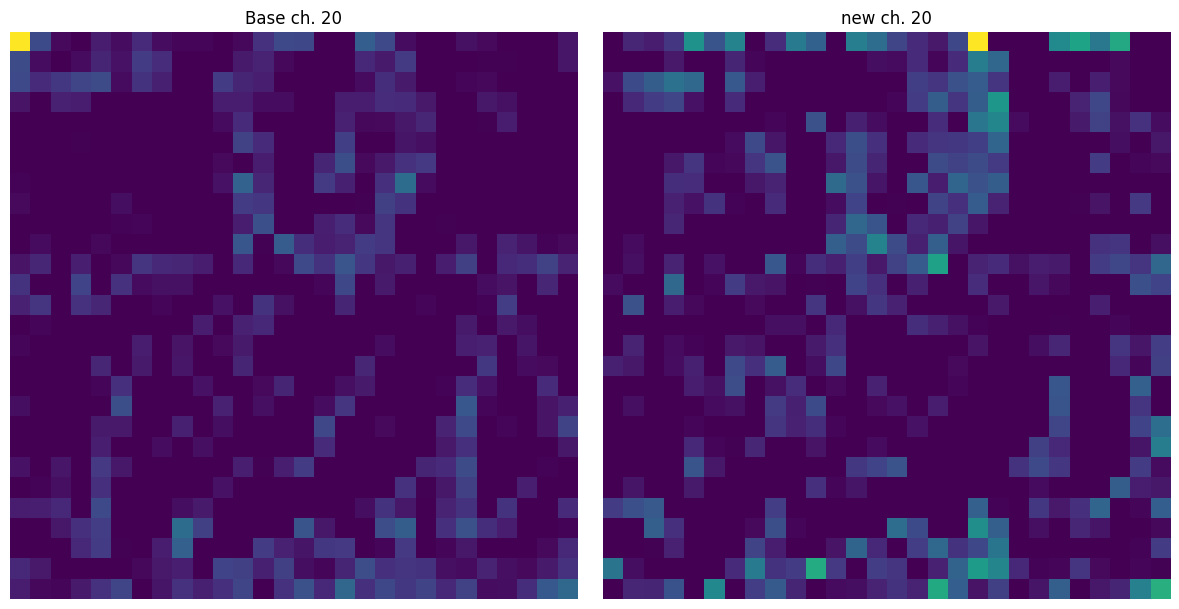

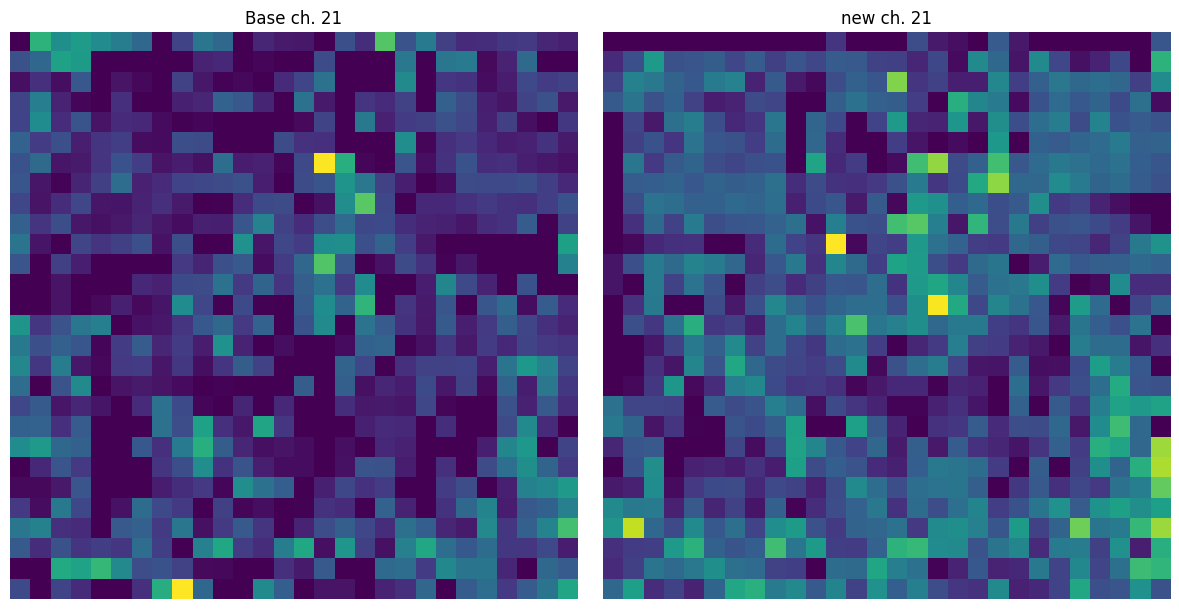

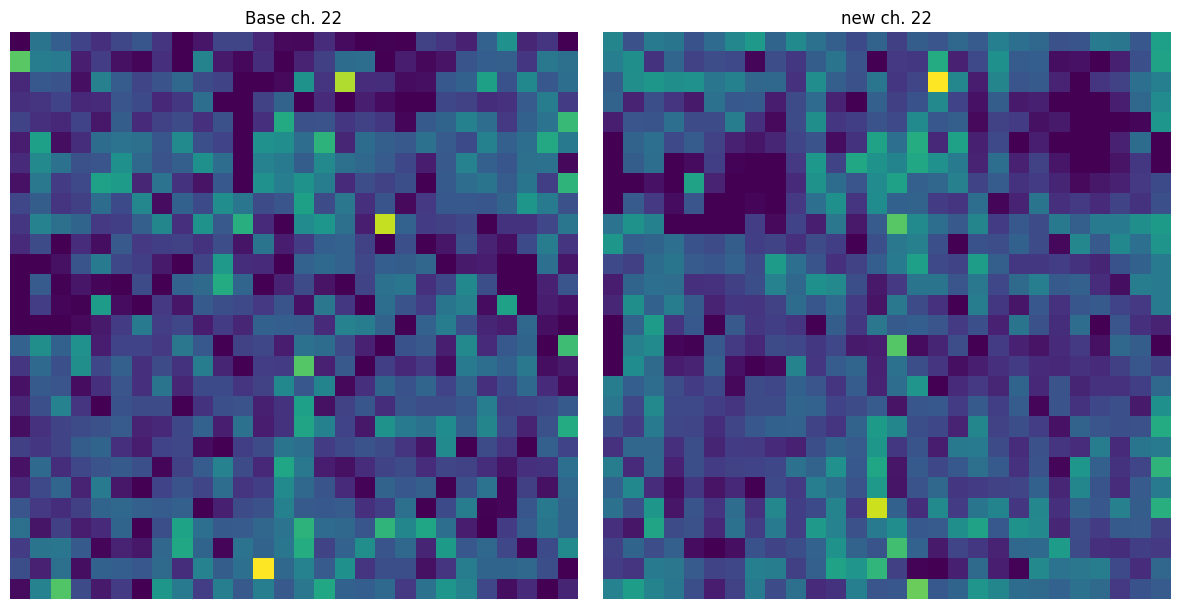

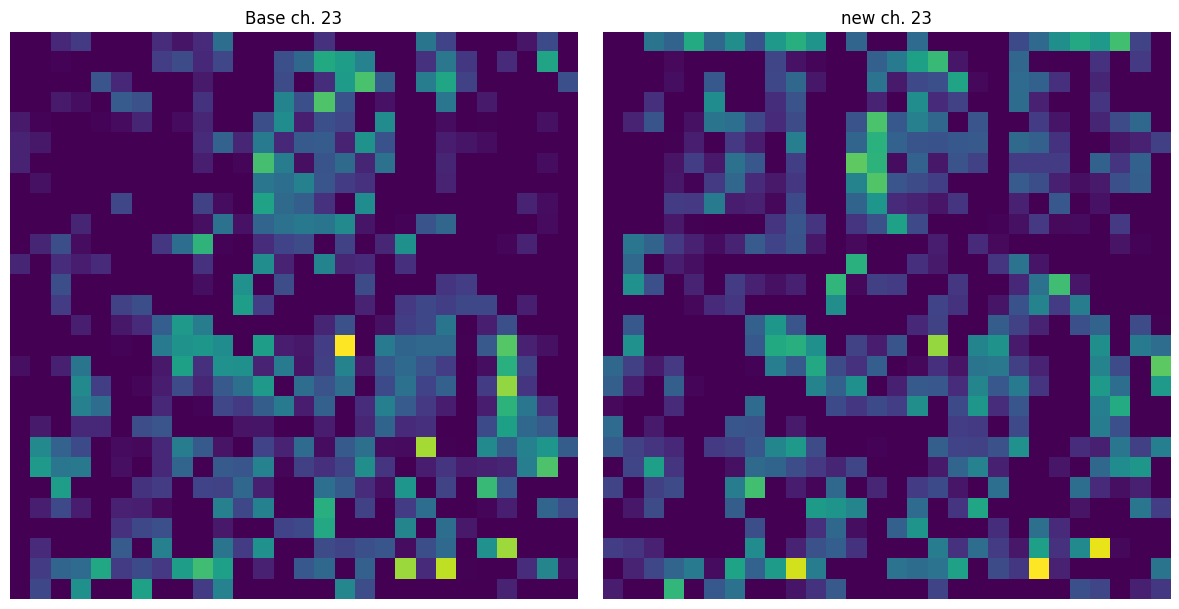

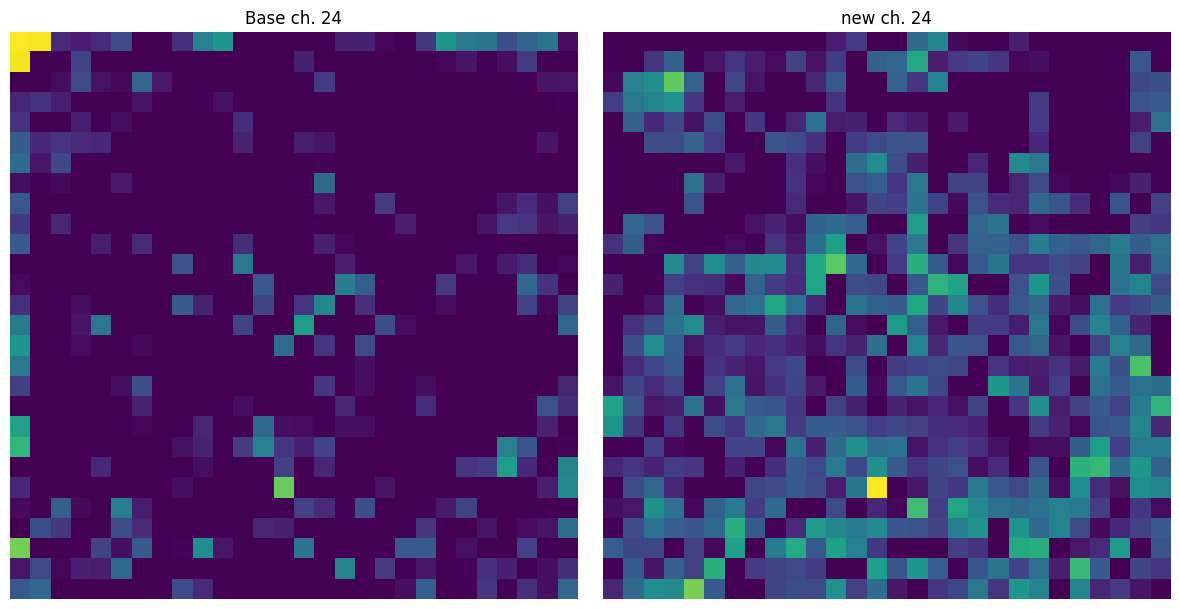

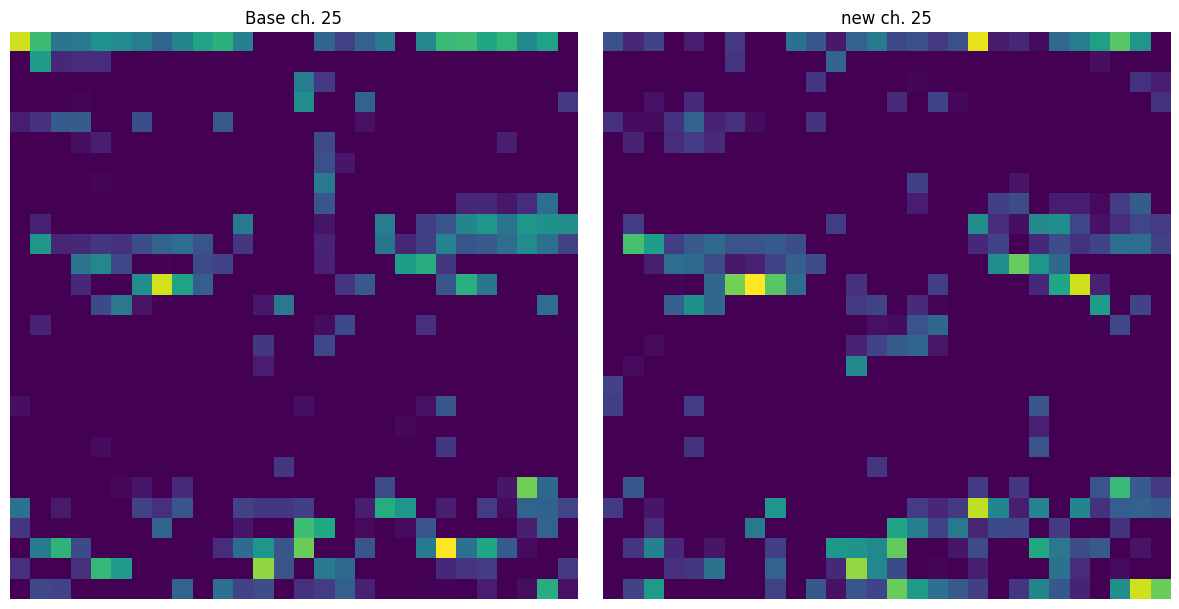

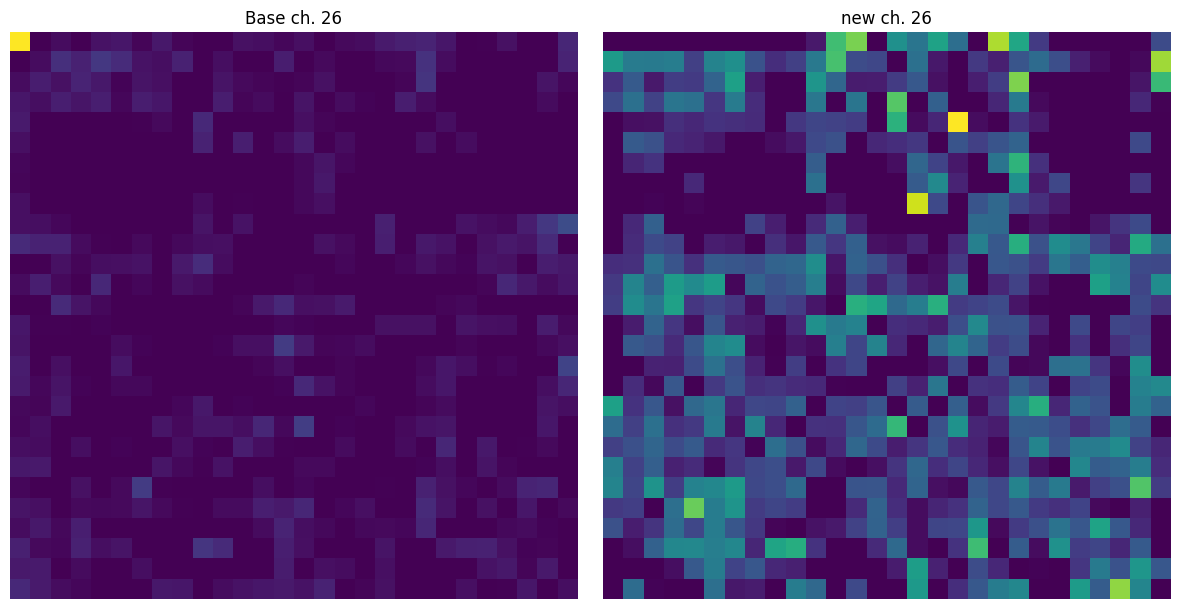

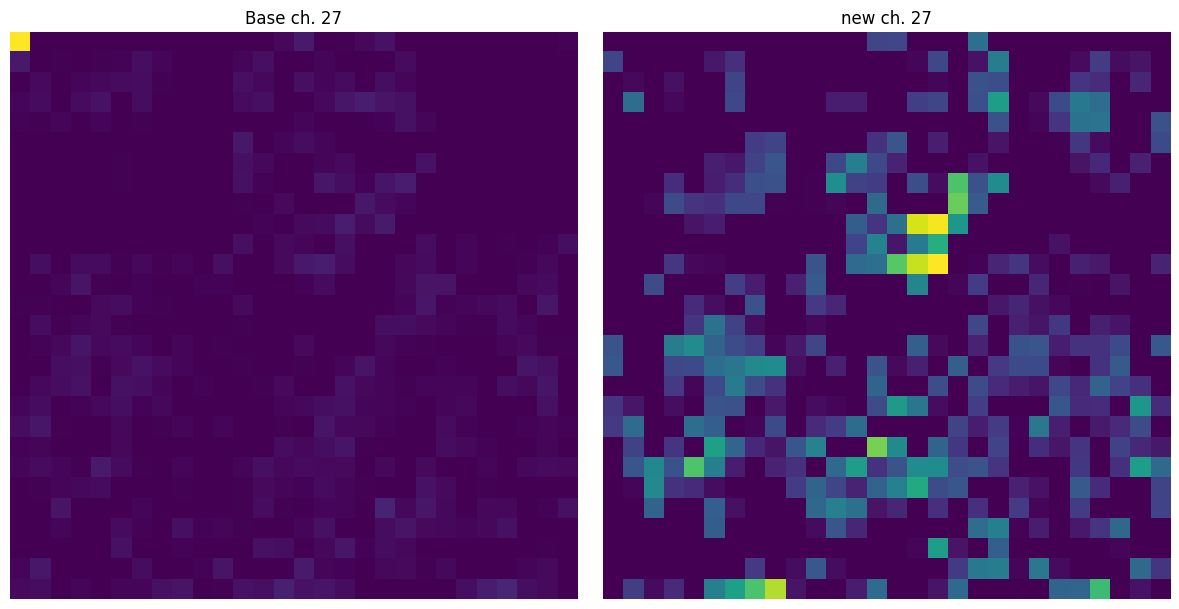

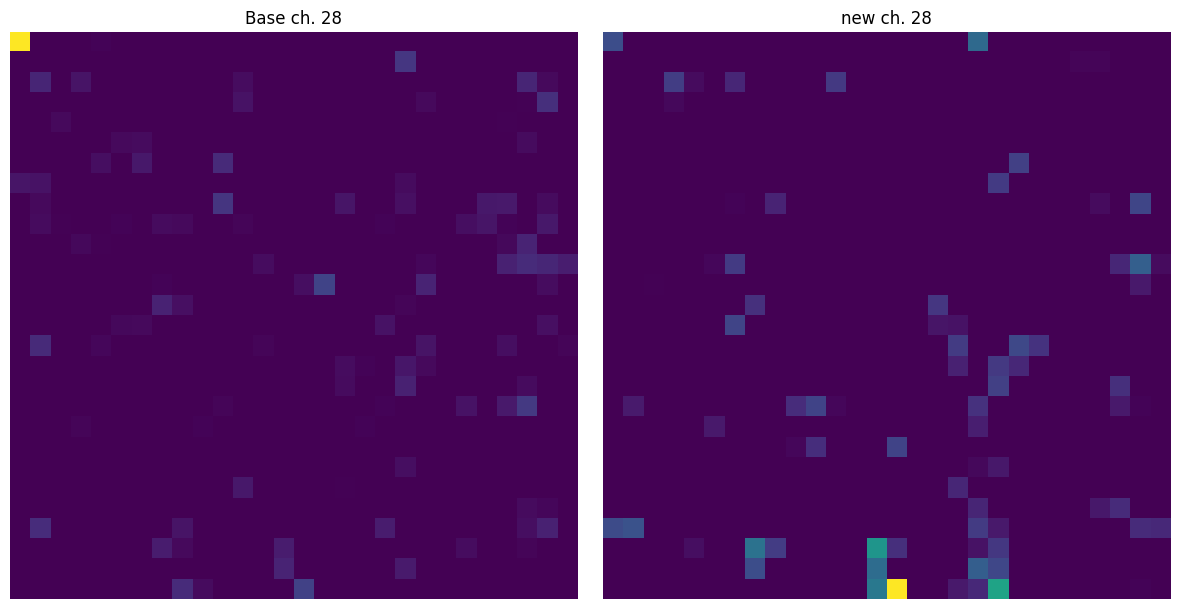

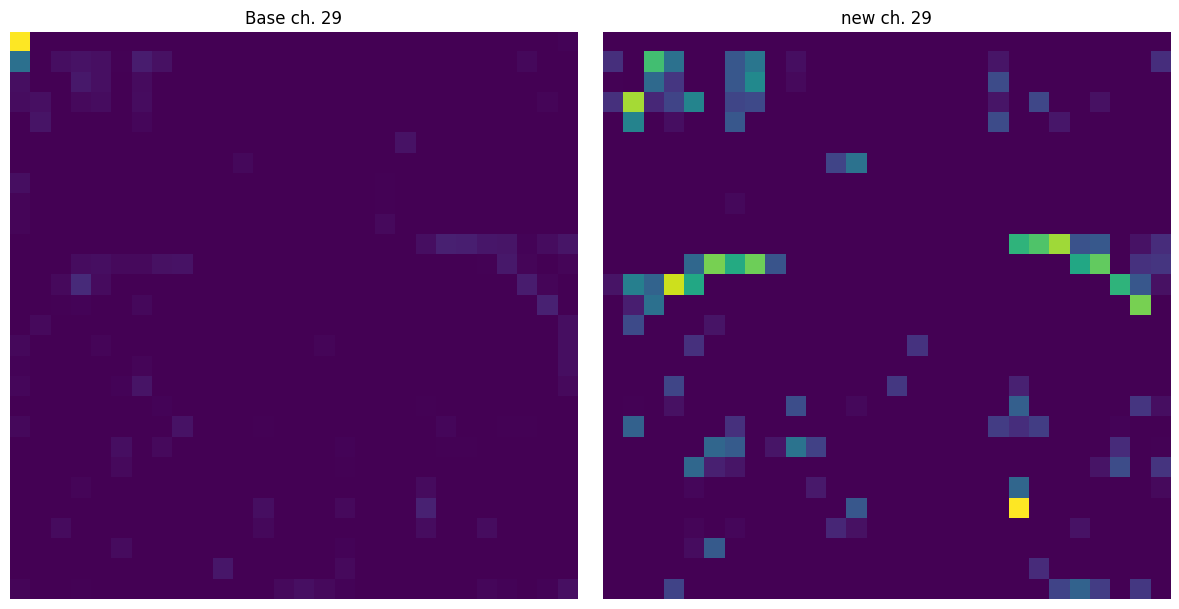

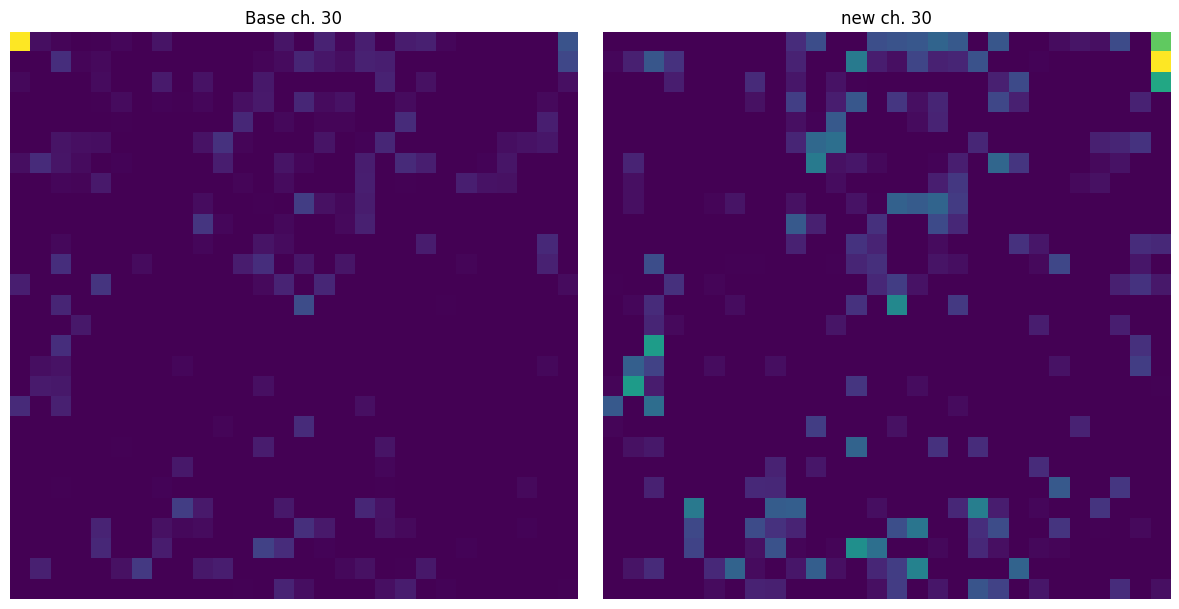

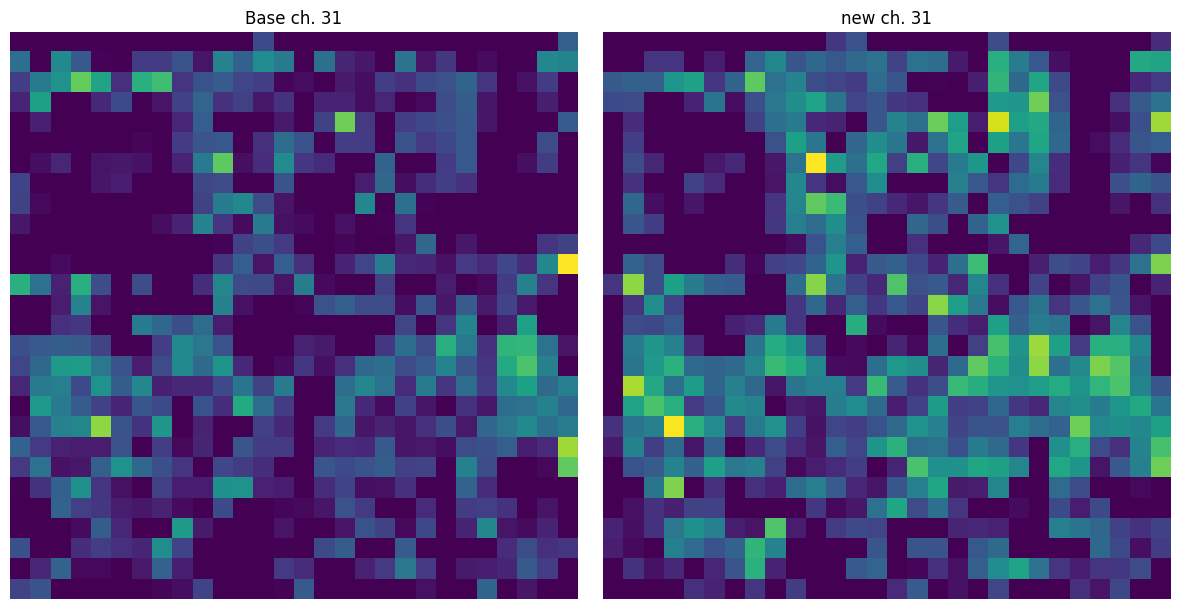

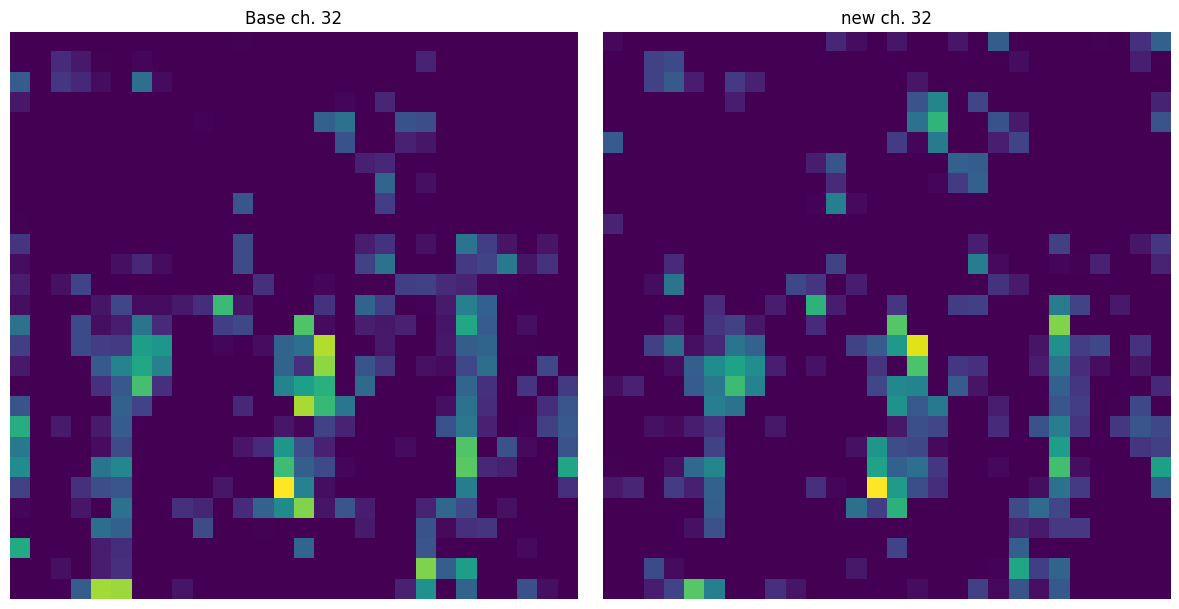

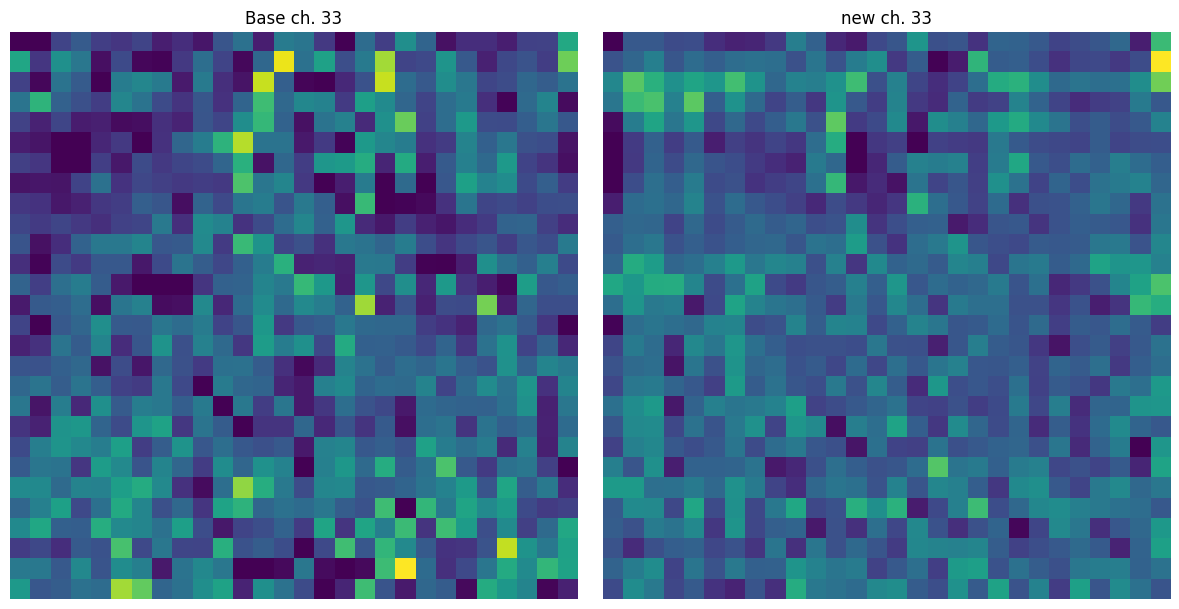

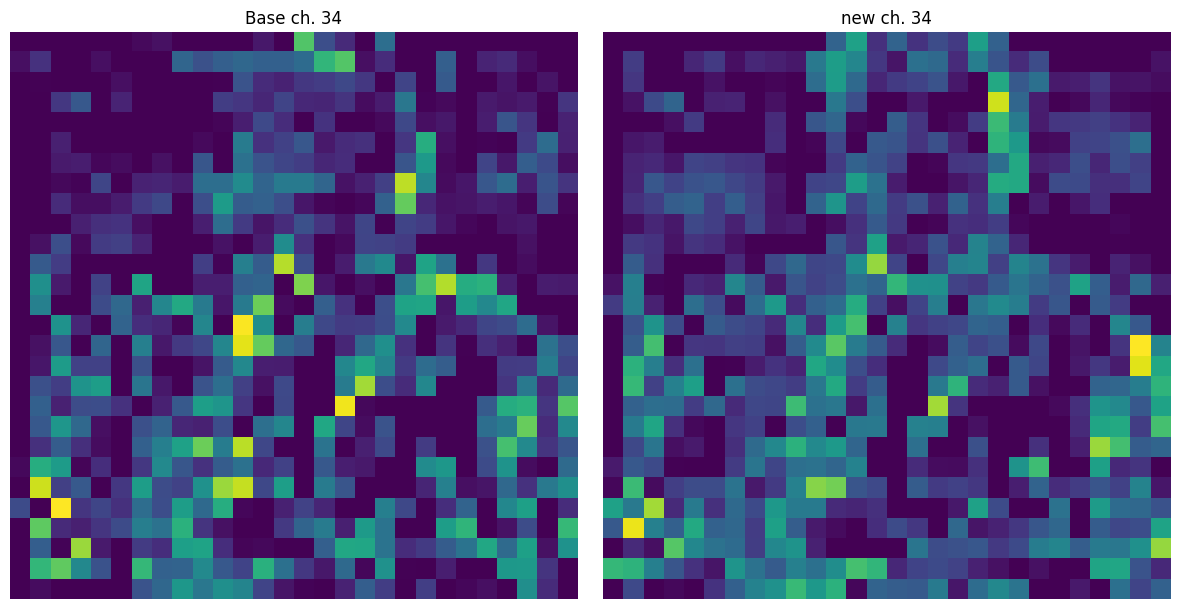

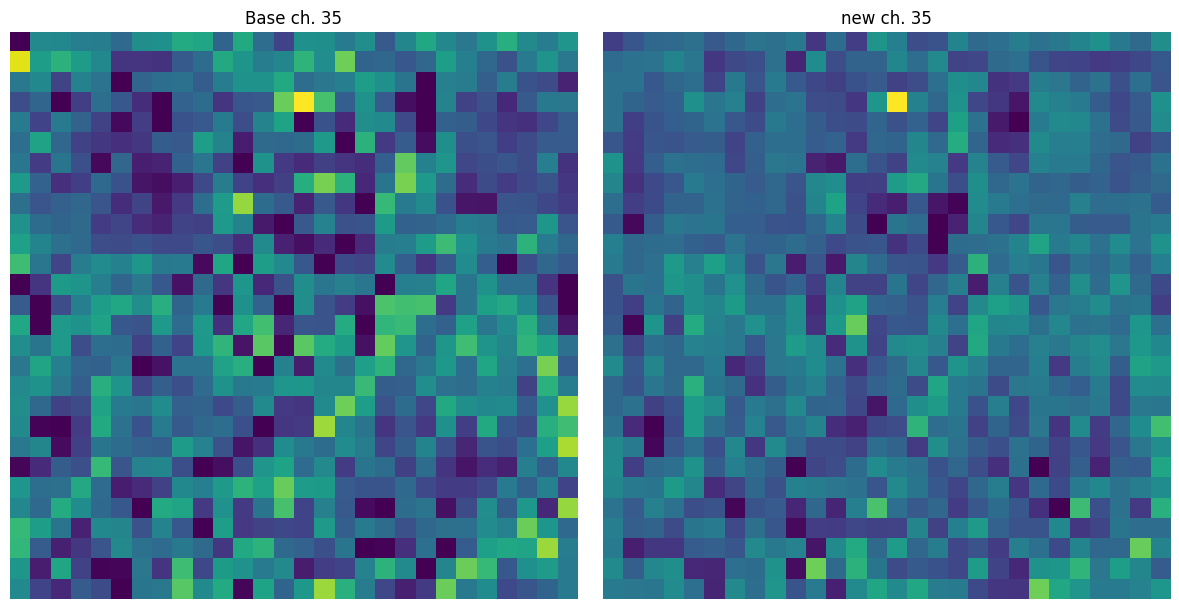

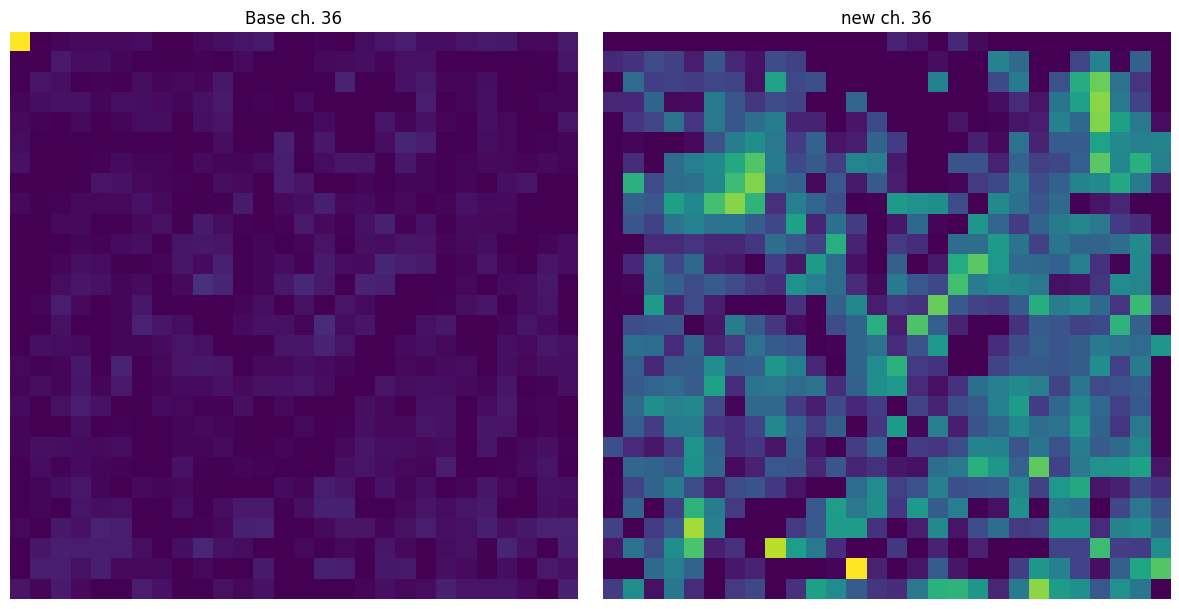

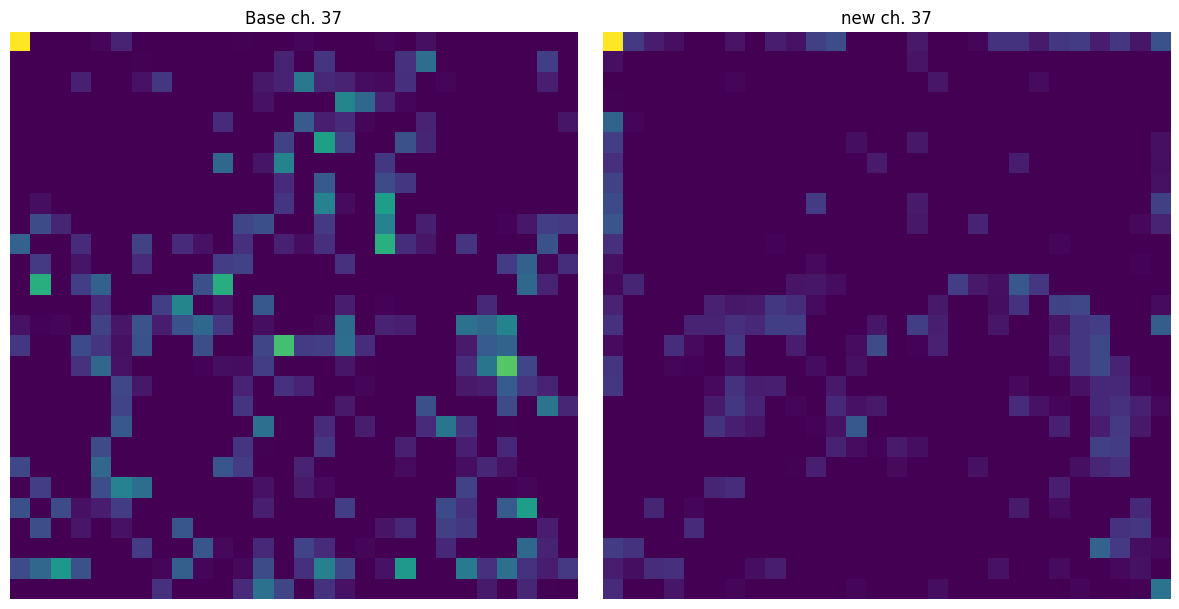

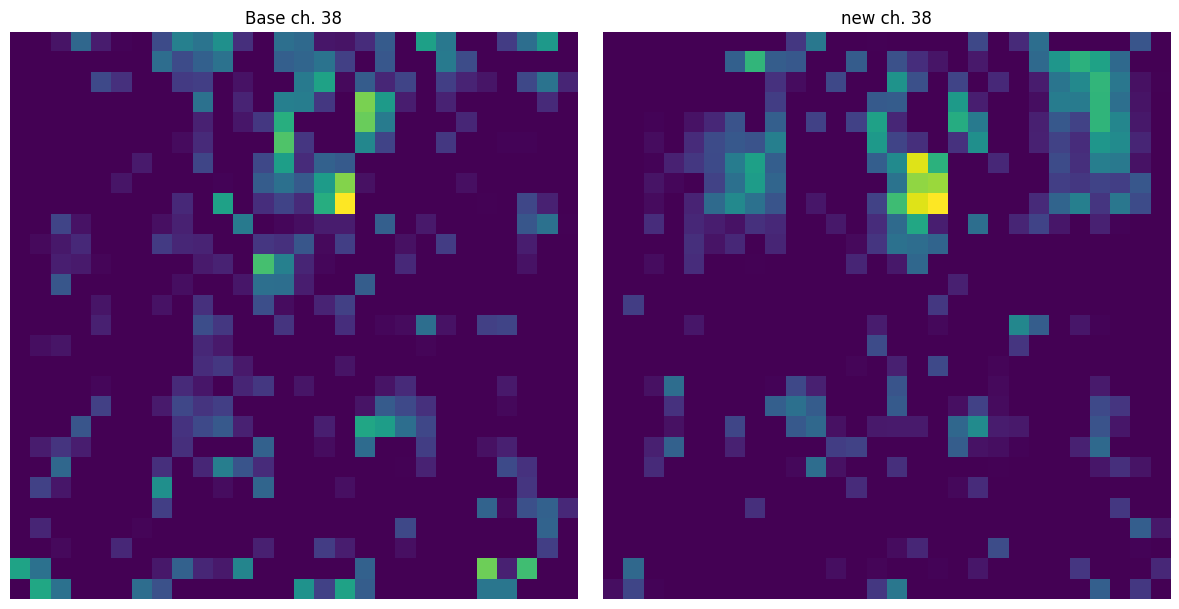

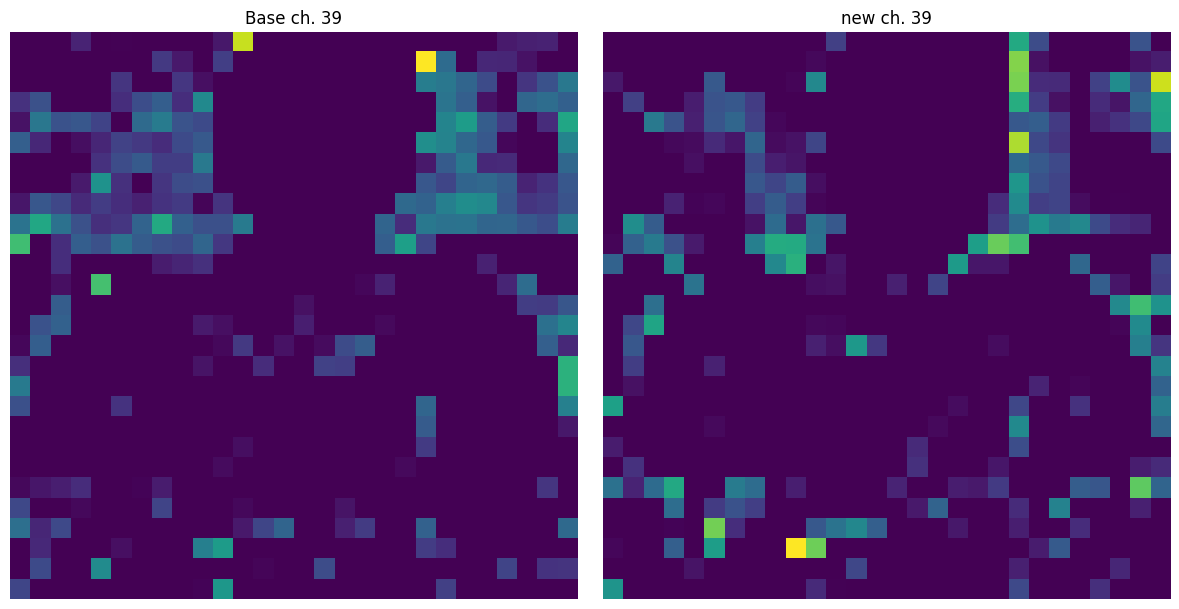

In [33]:
import matplotlib.pyplot as plt

def plot_side_by_side(layer, model2_type='baseline'):
    """
    Plot side by side the feature maps from your TPP model and a comparison model.
    
    Parameters:
        layer (int): The layer number to display (e.g. 3 or 5)
        model2_type (str): Determines the second image:
            - 'baseline': uses "output" (for layer 3 comparisons)
            - 'resnet': uses "output_resnet" (for layer 5 comparisons)
    """
    resnet50_features = nn.Sequential(*list(resnet50.children())[:-2-(5-layer)])
    output_resnet = resnet50_features(img_batch)
    
    def normalize_feature_map(feature_map):
        """Normalize feature map to [0, 1] range"""
        f_min = feature_map.min()
        f_max = feature_map.max()
        return (feature_map - f_min) / (f_max - f_min + 1e-8)
    
    # Loop over 20 channels (or adjust the range as needed)
    for idx in range(20,40):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Extract and show feature map from your TPP model (left side)
        img_tpp = output_tpp[f'res{layer}'][:, idx, :, :].squeeze(0).detach().numpy()
        img_tpp = normalize_feature_map(img_tpp)
        axes[0].imshow(img_tpp, cmap='viridis')
        axes[0].set_title(f"Base ch. {idx}")
        axes[0].axis("off")
        
        # Extract and show feature map from the second model (right side)
        if model2_type == 'baseline':  # For layer 3 comparison, for example
            img_baseline = output[f'res{layer}'][:, idx, :, :].squeeze(0).detach().numpy()
            img_baseline = normalize_feature_map(img_baseline)
            axes[1].imshow(img_baseline, cmap='viridis')
            axes[1].set_title(f"new ch. {idx}")
        elif model2_type == 'resnet':  # For layer 5 comparison, e.g. ResNet50 features
            img_resnet = output_resnet[:, idx, :, :].squeeze(0).detach().numpy()
            img_resnet = normalize_feature_map(img_resnet)
            axes[1].imshow(img_resnet, cmap='viridis')
            axes[1].set_title(f"ResNet50 Features - Channel {idx}")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

# # Example usage:
# # For layer 3 (comparing your TPP model to the baseline model)
# plot_side_by_side(layer=4, model2_type='baseline')

# For layer 5 (comparing your TPP model to ResNet50 features)
plot_side_by_side(layer=4, model2_type='baseline')

In [444]:
import torch.nn.functional as F

def compute_affinity_map(teacher_features):
    """Compute normalized patch-wise affinity map from teacher features."""
    # Assuming teacher_features is BxCxHxW
    B, C, H, W = teacher_features.shape
    patch_features = teacher_features.flatten(2)  # shape: [B, C, H*W]
    patch_features = F.normalize(patch_features, p=2, dim=1)  # normalize feature vectors along the channel dim

    # Compute cosine similarity between patches:
    corrs = torch.matmul(patch_features.transpose(1, 2), patch_features)  # shape: [B, H*W, H*W]
    corrs = corrs.reshape(B, H, W, H * W).permute(0, 3, 1, 2)  # reshape to expected format: [B, H*W, H, W]
    return corrs

affinity_map = compute_affinity_map(output_tpp[f'res5'])

In [ ]:

# Choose a random pixel
random_x =  2 # Random x coordinate (0-15)
random_y =  3 # Random y coordinate (0-15)

# Get the similarity map for the chosen pixel
pixel_similarity = affinity_map[0, random_y * 7 + random_x, :, :].cpu().detach().numpy()
# Plot the original image and similarity map
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img)
axes[0].scatter([random_x * 32], [random_y * 32], c='red', s=100)  # Mark the chosen pixel
axes[0].set_title(f"Original Image (Pixel: {random_x}, {random_y})")
axes[0].axis('off')

# Similarity map
im = axes[1].imshow(pixel_similarity, cmap='viridis')
plt.colorbar(im, ax=axes[1])
axes[1].set_title(f"Pixel Similarity Map for ({random_x}, {random_y})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
resnet50.children()

In [ ]:
from models.dinov2 import DINOv2ViT

dino = DINOv2ViT(model_name='dinov2_vits14')

In [ ]:
dino(img_batch)['feature_map'].shape

In [ ]:
plt.imshow(dino(img_batch)['feature_map'][:,31,:,:].squeeze(0).cpu().detach())

In [ ]:
import torch.nn as nn
f_match = nn.Conv2d(
                2048,
                2048,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True
            )
import torch
ckpt = torch.load('/home/arda/dinov2/distillation/logs/resnet50/distillation/dino_s_full_scalekd/checkpoints/last.ckpt',map_location='cpu')

w_student = {k.replace('student.feature_matchers.res5.matcher.0.', ''): v for k, v in ckpt['state_dict'].items() if 'student' in k and 'scalekd' not in k and 'feature_matchers' in k and 'res5' in k}
f_match.load_state_dict(w_student)






In [ ]:
import matplotlib.pyplot as plt

plt.imshow(f_match(output['res5'])[:,46,:,:].squeeze(0).detach().numpy(), cmap='viridis')

In [18]:
import os
data_dir = '/home/arda/data/train2017'
num_images = len([name for name in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, name))])
print(f"Number of images in the directory: {num_images}")


Number of images in the directory: 118288


In [66]:
interpolated = torch.nn.functional.interpolate(
                            output['res5'],
                            size=(16, 16),
                            mode='bilinear',
                            align_corners=False
                        )

In [ ]:
plt.imshow(f_match(interpolated)[:,9,:,:].squeeze(0).detach().numpy(), cmap='viridis')

In [ ]:
f_match(interpolated).shape

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data as a list of dictionaries (easier to copy-paste) ---
data = [
    {'folder': '/home/arda/anyma/output/imagenet_ema', 'Distilled From': '-', 'Distillation Type': '-', 'starting weights': '-', 'cosine similarity': '-', 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 35.13, 'AP50': 50.82, 'AP75': 38.14},
    {'folder': '/home/arda/anyma/output/Small', 'Distilled From': 'DiNov2-S', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 85.85, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'FALSE', 'AP': 36.87, 'AP50': 53.4, 'AP75': 40.25},
    {'folder': '/home/arda/anyma/output/Base', 'Distilled From': 'DiNov2-B', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 80.85, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'FALSE', 'AP': 37.35, 'AP50': 53.95, 'AP75': 40.72},
    {'folder': '/home/arda/anyma/output/Large', 'Distilled From': 'DiNov2-L', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 75.82, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'FALSE', 'AP': 36.91, 'AP50': 53.68, 'AP75': 40.08},
    {'folder': '/home/arda/anyma/output/small_ema', 'Distilled From': 'DiNov2-S', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 85.85, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 38.49, 'AP50': 55.05, 'AP75': 41.8},
    {'folder': '/home/arda/anyma/output/base_ema', 'Distilled From': 'DiNov2-B', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 80.85, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 38.4, 'AP50': 54.92, 'AP75': 41.83},
    {'folder': '/home/arda/anyma/output/large_ema', 'Distilled From': 'DiNov2-L', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 75.82, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 38.42, 'AP50': 55.2, 'AP75': 41.53},
    {'folder': '/home/arda/anyma/output/small_ema_448', 'Distilled From': 'DiNov2-S', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 86.33, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 38.55, 'AP50': 55.24, 'AP75': 42.0},
    {'folder': '/home/arda/anyma/output/stdc2_original', 'Distilled From': 'DiNov2-S', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': '-', 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 27.85, 'AP50': 40.58, 'AP75': 30.16},
    {'folder': '/home/arda/anyma/output/stdc1_original', 'Distilled From': 'DiNov2-S', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': '-', 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 27.43, 'AP50': 40.32, 'AP75': 29.68},
    {'folder': '/home/arda/anyma/output/stdc2_distilled', 'Distilled From': 'DiNov2-S', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 83.5, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 32.08, 'AP50': 47.17, 'AP75': 34.86},
    {'folder': '/home/arda/anyma/output/stdc1_distilled', 'Distilled From': 'DiNov2-S', 'Distillation Type': 'ScaleKD', 'starting weights': 'Imagenet', 'cosine similarity': 82.4, 'Proxy Task': 'Detection', 'Augmentations': 'Anyma', 'Proxy Dataset': 'Coco', 'Iterations': '90k', 'ema_anyma': 'TRUE', 'AP': 31.41, 'AP50': 45.53, 'AP75': 34.22}
]

df = pd.DataFrame(data)

# --- Data Cleaning and Feature Engineering ---

# 1. Extract Model Size/Type from 'folder'
def extract_model_name(folder_path):
    folder_name = folder_path.split('/')[-1]
    if folder_name == 'imagenet_ema':
        return 'Imagenet EMA'
    elif folder_name.startswith('Small'):
        return 'Small' + (' EMA' if 'ema' in folder_name else '') + (' 448' if '448' in folder_name else '')
    elif folder_name.startswith('Base'):
        return 'Base' + (' EMA' if 'ema' in folder_name else '')
    elif folder_name.startswith('Large'):
        return 'Large' + (' EMA' if 'ema' in folder_name else '')
    elif folder_name.startswith('stdc2'):
        return 'STDC2 ' + ('Distilled' if 'distilled' in folder_name else 'Original')
    elif folder_name.startswith('stdc1'):
        return 'STDC1 ' + ('Distilled' if 'distilled' in folder_name else 'Original')
    else:
        return folder_name # Fallback

df['Model'] = df['folder'].apply(extract_model_name)

# 2. Convert Cosine Similarity to numeric, handle '-'
df['cosine similarity'] = pd.to_numeric(df['cosine similarity'], errors='coerce')

# 3. Convert ema_anyma to boolean
df['ema_anyma'] = df['ema_anyma'] == 'TRUE'

# 4. Melt DataFrame for easier plotting of AP metrics
df_melted_ap = pd.melt(df,
                       id_vars=['Model', 'ema_anyma', 'Distilled From', 'Distillation Type', 'cosine similarity'],
                       value_vars=['AP', 'AP50', 'AP75'],
                       var_name='Metric',
                       value_name='Value')


# --- Visualizations ---

# 1. Bar Chart: Comparing AP by Model, Hue by EMA
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted_ap, x='Model', y='Value', hue='ema_anyma', hue_order=[False, True],
            order=df['Model'].unique()) # Maintain order from DataFrame
plt.title('Comparison of Average Precision (AP, AP50, AP75) by Model and EMA')
plt.xlabel('Model Configuration')
plt.ylabel('Average Precision Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='EMA Applied')
plt.tight_layout()
plt.show()


# 2. Grouped Bar Chart: Separate bars for AP, AP50, AP75 for each Model
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted_ap, x='Model', y='Value', hue='Metric',
            order=df['Model'].unique()) # Maintain order from DataFrame
plt.title('Detailed AP Metrics (AP, AP50, AP75) by Model')
plt.xlabel('Model Configuration')
plt.ylabel('Average Precision Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


# 3. Scatter Plot: Cosine Similarity vs. AP (if cosine similarity is available)
df_cosine = df.dropna(subset=['cosine similarity']) # Drop rows with missing cosine similarity
if not df_cosine.empty:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_cosine, x='cosine similarity', y='AP', hue='Model', style='ema_anyma', s=100)
    plt.title('Relationship between Cosine Similarity and AP')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('AP')
    plt.legend(title='Model & EMA')
    plt.tight_layout()
    plt.show()
else:
    print("No cosine similarity data available for scatter plot.")


# 4. Focus on EMA Impact (Pairwise Comparison)
ema_models = df[df['Model'].str.contains('_ema|EMA')]
non_ema_models = df[~df['Model'].str.contains('_ema|EMA')]

# Merge to compare EMA vs Non-EMA pairs (assuming naming convention allows pairing)
merged_ema = pd.merge(non_ema_models, ema_models,
                     left_on=df['Model'][non_ema_models.index].str.replace('_ema', '').str.replace(' EMA','').str.replace(' 448','').str.strip(),
                     right_on=df['Model'][ema_models.index].str.replace('_ema', '').str.replace(' EMA','').str.replace(' 448','').str.strip(),
                     suffixes=('_no_ema', '_ema'))


if not merged_ema.empty:
    metrics = ['AP', 'AP50', 'AP75']
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        sns.barplot(x='Model_no_ema', y=f'{metric}_no_ema', data=merged_ema, color='skyblue', label='Without EMA')
        sns.barplot(x='Model_ema', y=f'{metric}_ema', data=merged_ema, color='coral', label='With EMA')
        plt.title(f'Impact of EMA on {metric}')
        plt.xlabel('Model Pair (Without/With EMA)')
        plt.ylabel(f'{metric} Value')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Could not create EMA impact comparison plot due to data structure.")

In [ ]:
import matplotlib.pyplot as plt
import PIL

img = PIL.Image.open('/storage/disk2/sam_resized/sa_1987704.jpg')

img